# Neural Network Classification with PyTorch

## 1. Make classification data

In [4]:
import sklearn
from sklearn.datasets import make_circles

# make 1k samples
n_samples = 1000

# create cricles
X, y = make_circles(n_samples, noise=0.03, random_state=42)
len(X), len(y)

(1000, 1000)

In [6]:
# First 5 samples
print(f"First 5 samples of X:\n {X[:5]}") # coordinates
print(f"First 5 samples of y:\n {y[:5]}") # color

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [9]:
# make a dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


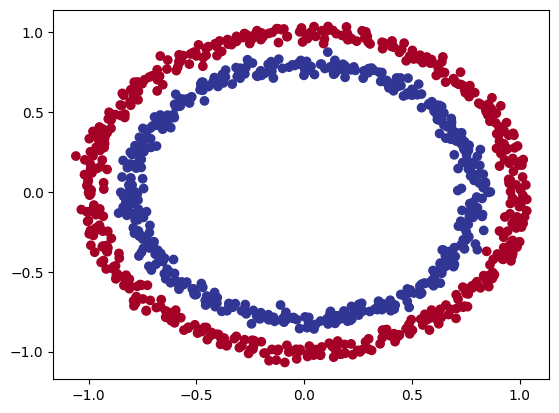

In [11]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Check input and output shapes

In [12]:
X.shape, y.shape

((1000, 2), (1000,))

In [14]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(X_sample, y_sample)
print(X_sample.shape, y_sample.shape)

[0.75424625 0.23148074] 1
(2,) ()


### Convert data into tensors and create train/test split

In [15]:
import torch

In [16]:
# turn into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [17]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

800 200
800 200


## 2. Building a model
1. Setup device agnostic code
2. Construct a model by subclassing nn.Module
3. Define loss funtion and optimizer
4. Create training and test loops

### 2.1 Devicec agnostic code

In [18]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 2.2 Construct a model
1. Sublcass `nn.Module`
2. Create 2 `nn.Linear()` layers that handle the shapes of our data
3. Define a `forward()` method that outlines the forward pass (computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [21]:
# 1. Subclass nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    
    # 2. Create 2 linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # input layer
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # hidden layer

  # 3. Forward method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer 1 -> layer 2 -> output
  
# 4. Model instance
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
device, next(model_0.parameters()).device

('cpu', device(type='cpu'))

In [24]:
# Replicate the model with nn.Sequential
model_0 = nn.Sequential(
  nn.Linear(in_features=2, out_features=5),
  nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2637,  0.4689],
                      [ 0.4973, -0.4480],
                      [ 0.6546, -0.5332],
                      [-0.3045,  0.2155],
                      [-0.5370,  0.1627]])),
             ('0.bias', tensor([ 0.2339,  0.0921,  0.1340,  0.3438, -0.3079])),
             ('1.weight',
              tensor([[ 0.0817,  0.4194,  0.2007, -0.3702,  0.4084]])),
             ('1.bias', tensor([0.3466]))])

In [29]:

with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of preds: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 preds:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of preds: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 preds:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]])

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer
* Regression: MAE or MSE
* Classification: cross entropy (categorical or binary)

In [30]:
# Binary cross-entropy loss
loss_fn = nn.BCEWithLogitsLoss() # sigmoid acitvation function
# nn.BCELoss requires inputs to pass through sigmoid activation function

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)


In [31]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return correct / len(y_pred) * 100

## 3. Train the model

Training loop:
1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backward (backpropogation)
5. Optimizer step (gradient step)

### 3.1 Going from raw logits to prediction probabilities to prediction labels
Model outputs raw logits. Convert these logits into prediction probabilities with a sigmoid or softmax activation function. Take argmax() to get prediction labels.

In [33]:
# view the first 5 outputs of forward pass on test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1017],
        [-0.0770],
        [ 0.0840],
        [-0.1554],
        [ 0.4815]])

In [34]:
# use sigmoid activation function on logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4746],
        [0.4808],
        [0.5210],
        [0.4612],
        [0.6181]])

In [36]:
# find the predicted labels
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

### 3.2 Building a training and testing loop

In [42]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probs -> labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, ##BCEWithLogits expects raw logits as input
                 y_train)
  
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. optimizer step (grad descent)
  optimizer.step()


  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Test loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what's happenin'
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss:{test_loss:5f}, Test acc: {test_acc:.2f}%")
    

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 0 | Loss: 0.70520, Acc: 51.38% | Test loss:0.699684, Test acc: 56.00%
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 w

In [43]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

## 4. Make predictions and evaluate the model


In [52]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo if it's not already downloaded
if Path("helper_functions.py").is_file():
  print("Already exists")
else: 
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

#from helper_functions import plot_predictions, plot_decision_boundary

Already exists


ImportError: cannot import name 'plot_predictions' from 'helper_functions' (/Users/alexgeorgiev/Desktop/pytorch-dan/helper_functions.py)

In [56]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

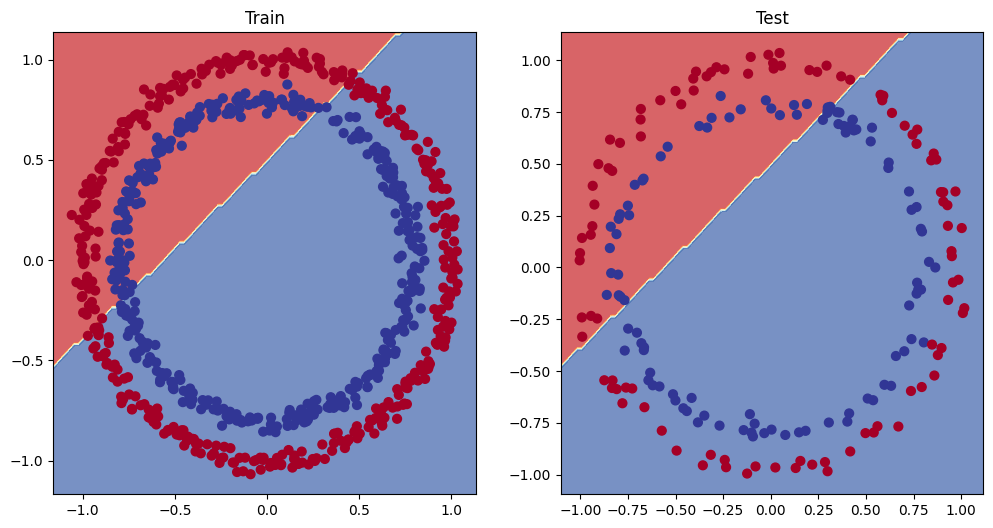

In [59]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5. Improving a model
* Add more layers
* Add more hidden units
* Fit for longer
* Change activation functions
* Change learning rate
* Change the loss function

In [68]:
# add more hidden units and increase the number of layers
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [69]:
# create loss function
loss_fn = nn.BCEWithLogitsLoss()

# create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [71]:
# Training and Evaluation loop
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# put data on target advice
X_train, y_train = X_train.to(device), y_train.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train) 
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. backprop
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 w

## 6. Nonlinearity

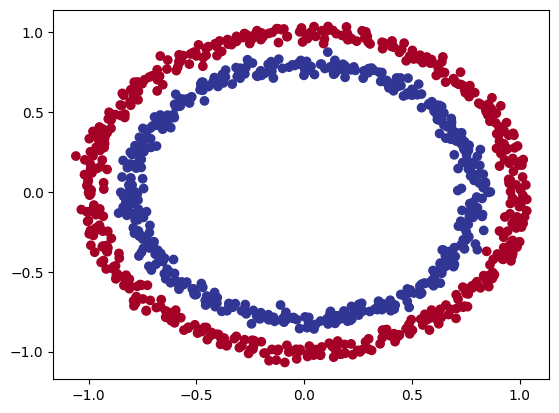

In [72]:
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [73]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(y_test)


(800, 200)

### 6.2 Building a model with nonlinearity

In [83]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
  
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [86]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimzier = torch.optim.SGD(model_3.parameters(), lr=0.01)

### 6.3 Train the nonlinear model

In [87]:
# torch.manual_seed(42)
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

# # training and evaluation loop
# epochs = 1000
# for epoch in range(epochs):
#   model_3.train()
#   y_logits = model_3(X_train).squeeze()
#   y_pred = torch.round(torch.sigmoid(y_logits))

#   # loss
#   loss = loss_fn(y_logits, y_train)
#   acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

#   optimzier.zero_grad()
#   loss.backward()
#   optimizer.step()

#   ### Testing
#   model_3.eval()
#   with torch.inference_mode():
#     test_logits = model_3(X_test).squeeze()
#     test_pred = torch.round(torch.sigmoid(test_logits))
#     test_loss = loss_fn(test_logits, y_test)
#     test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

#     if epoch == 0 or epoch == 500 or epoch == 999:
#       print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% \n Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 0 | Loss: 0.6929, Acc: 50.00% 
 Test loss: 0.6933, Test acc: 50.00%
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 wil

In [91]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch == 0 or epoch == 999:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Inte

### 6.4 Evaluating nonlinear model performance

In [92]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

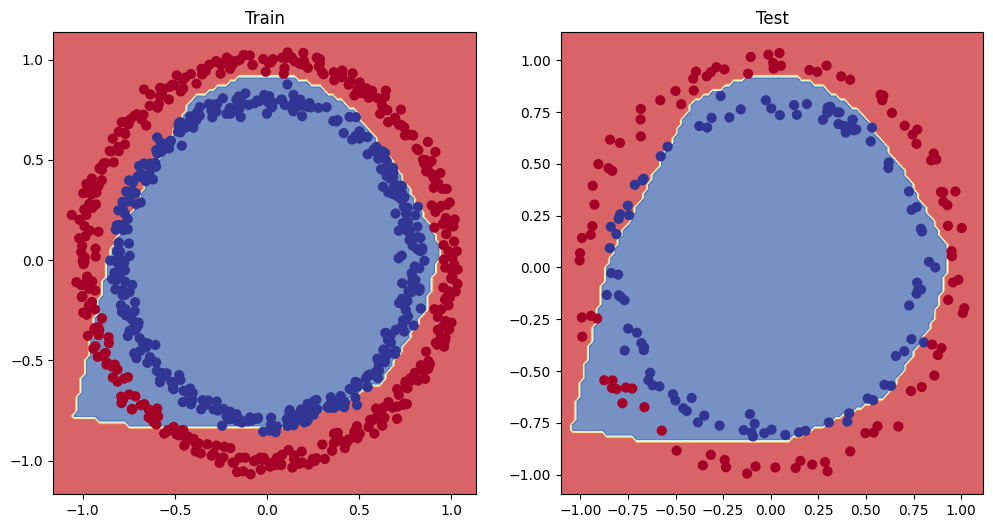

In [93]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating nonlinear activation functions

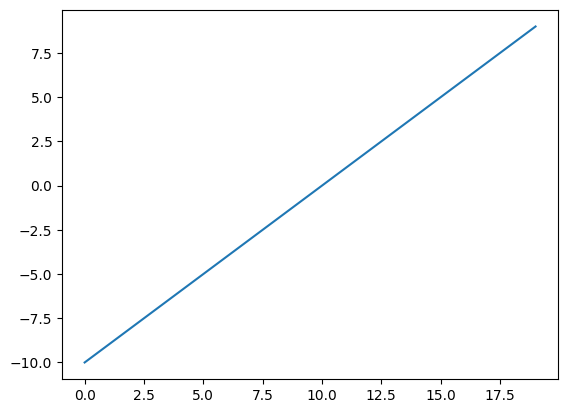

In [94]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)

# visualize
plt.plot(A)

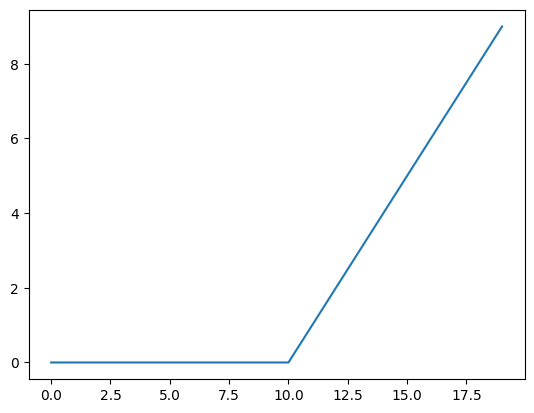

In [95]:
plt.plot(torch.relu(A))

In [96]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

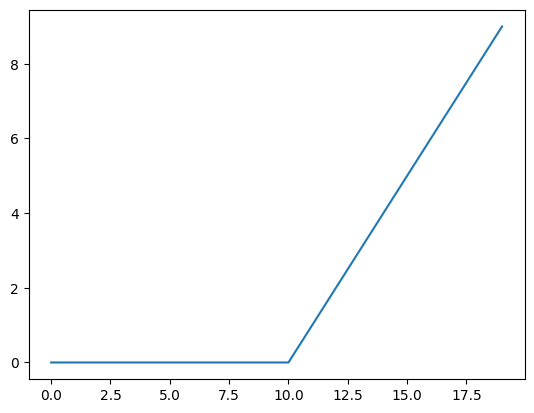

In [97]:
plt.plot(relu(A))

In [100]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

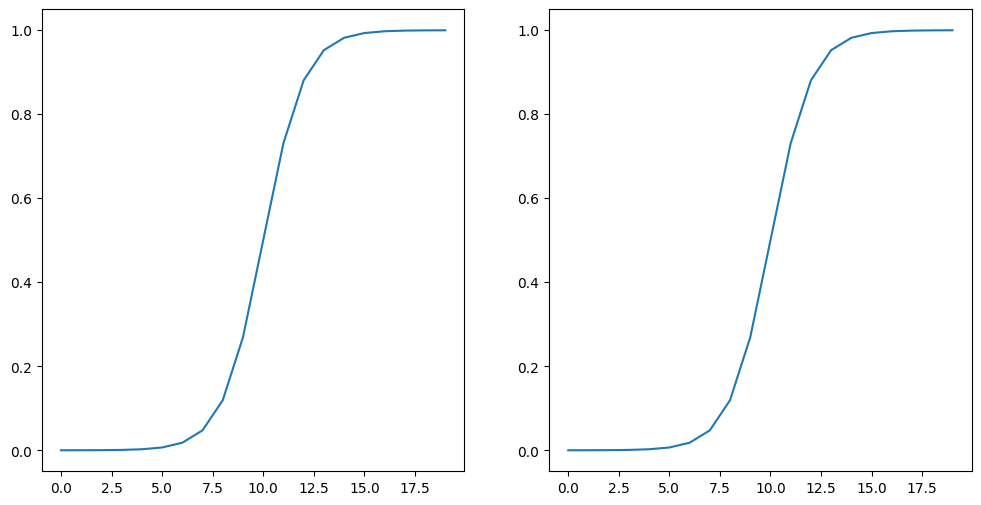

In [101]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(torch.sigmoid(A))
plt.subplot(1, 2,2)
plt.plot(sigmoid(A))

## 8. Multi-class classification

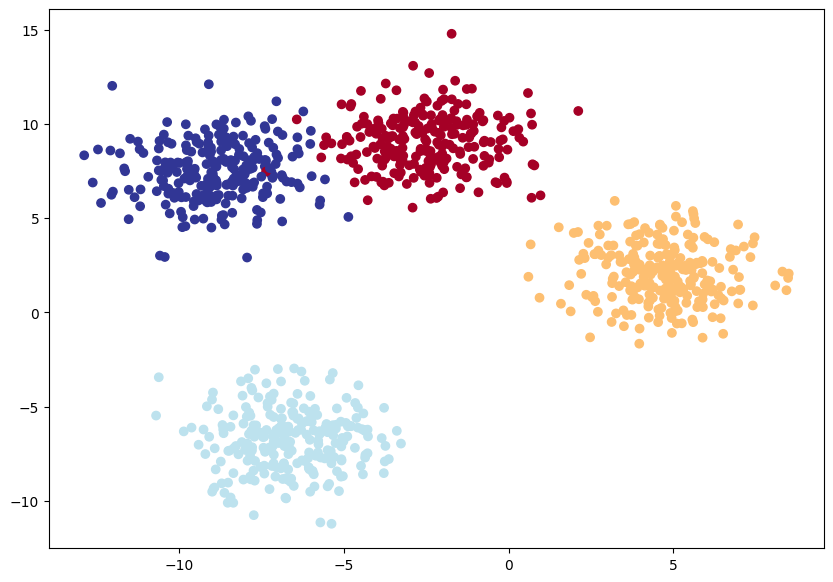

In [134]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameteres for data creating
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. split into train/test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. visualize
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


### 8.2 Build a multiclass classification model

In [135]:
torch.unique(y_blob_train), X_blob_train.shape

(tensor([0, 1, 2, 3]), torch.Size([800, 2]))

In [136]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [137]:
class BlobModel(nn.Module):
  def __init__(self, input_feautres, out_features, hidden_units=8):
    """Initializes multclass classification model

    Args:
      input_feautres (int): number of input features to the model
      out_features (int): number of output classes
      hidden_units (int): number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_feautres, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)
  
model_4 = BlobModel(input_feautres=2, out_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create loss function and optimizer

In [138]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### 8.4 Get prediction probabilities

In [139]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test) # logits
print(y_logits[:5])

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [140]:
y_pred = torch.argmax(y_pred_probs, dim=1)
y_pred

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

### 8.5 Training/testing loop

In [143]:
torch.manual_seed(42)
epochs = 100


X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)
    if epoch % (epochs/10) == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.98 | Test loss: 0.9413, Test acc: 64.00%
Epoch: 10 | Loss: 0.60 | Test loss: 0.6128, Test acc: 98.00%
Epoch: 20 | Loss: 0.39 | Test loss: 0.3907, Test acc: 100.00%
Epoch: 30 | Loss: 0.22 | Test loss: 0.2088, Test acc: 99.50%
Epoch: 40 | Loss: 0.10 | Test loss: 0.0884, Test acc: 99.50%
Epoch: 50 | Loss: 0.06 | Test loss: 0.0543, Test acc: 99.50%
Epoch: 60 | Loss: 0.05 | Test loss: 0.0410, Test acc: 99.50%
Epoch: 70 | Loss: 0.04 | Test loss: 0.0337, Test acc: 99.50%
Epoch: 80 | Loss: 0.04 | Test loss: 0.0291, Test acc: 99.50%
Epoch: 90 | Loss: 0.03 | Test loss: 0.0261, Test acc: 99.50%


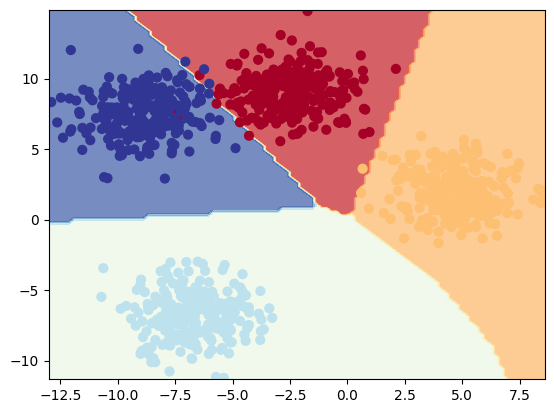

In [144]:
plot_decision_boundary(model_4, X_blob, y_blob)

### 8.6 Making and evaluating predictions

In [145]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[-0.6265,  6.0263, -7.6651, -8.4859],
        [-2.1884, -6.4025, -3.7404,  3.1544],
        [-3.4378, -3.9215,  3.1833, -2.6303],
        [-1.1572,  4.2257, -3.8657, -4.9030],
        [ 3.7878, -1.3366, -9.1821, -6.9863],
        [-2.8353, -7.6102, -4.3199,  3.8288],
        [-3.0547, -3.3553,  2.8184, -2.1533],
        [ 3.4042, -4.0514, -6.9310, -3.5718],
        [-4.3962, -5.0225,  3.8457, -3.4044],
        [ 3.5306, -3.0359, -7.5747, -4.7342]])

In [146]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.2887e-03, 9.9871e-01, 1.1306e-06, 4.9757e-07],
        [4.7544e-03, 7.0295e-05, 1.0071e-03, 9.9417e-01],
        [1.3252e-03, 8.1698e-04, 9.9489e-01, 2.9716e-03],
        [4.5713e-03, 9.9502e-01, 3.0462e-04, 1.0796e-04],
        [9.9406e-01, 5.9140e-03, 2.3154e-06, 2.0810e-05],
        [1.2739e-03, 1.0750e-05, 2.8866e-04, 9.9843e-01],
        [2.7813e-03, 2.0591e-03, 9.8831e-01, 6.8500e-03],
        [9.9846e-01, 5.7730e-04, 3.2419e-05, 9.3263e-04],
        [2.6309e-04, 1.4063e-04, 9.9889e-01, 7.0933e-04],
        [9.9832e-01, 1.4043e-03, 1.5007e-05, 2.5699e-04]])

In [147]:
y_preds = y_pred_probs.argmax(dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

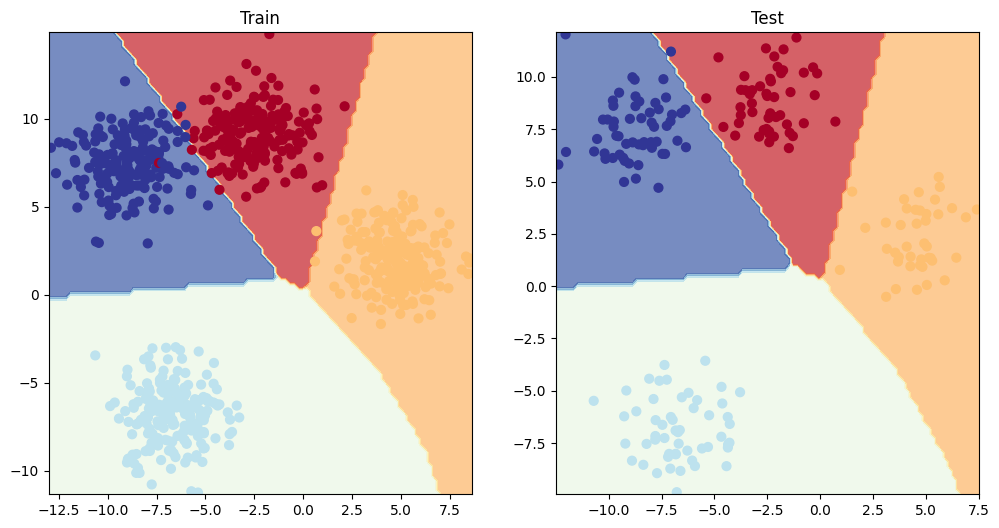

In [152]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. Classification metrics
* Accuracy
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [159]:
# from torchmetrics import Accuracy

# # setup metric
# torchmetric_accuracy = Accuracy('multiclass').to(device)

# # calculate accuracy
# torchmetric_accuracy(y_preds, y_blob_test)